## Import

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.model_selection import train_test_split

In [2]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plotter_corr(val):
    np.random.seed(42)
    if val < 0:
        coeff = -1
    else:
        coeff = 1

    x = np.linspace(0,10,101)
    noise = np.random.normal(0,np.abs(val),101)
    y = coeff * 2 * x + 1.5 + noise

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    axs.scatter(x,y)
    confidence_ellipse(x,y,axs,edgecolor='red')
    plt.show()

    print(f"Correlation coefficient: {np.corrcoef(x,y)[0][1]}")
    print(f"Covariance X and Y: {cov(x,y)[0][1]}")
    
    
def playground_corr():
    pelemparan_slider = widgets.SelectionSlider(
        options=[-100, -50, -20, -10, -5, -1, -0.5, -0.2, -0.1, 
                 0 , 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 100],
        value=0,
        description='randomness:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )

    print("Masukkan 'Randomness':")
    interact(plotter_corr, val=pelemparan_slider);
    
    
def plot_randomness():
    randomness=[-100, -75,-50, -20, -10, -5, -1, -0.5, -0.2, -0.1, 
            0 , 0.1, 0.2, 0.5, 1, 5, 10, 20, 50, 75, 100]
    corr_val = []
    cov_val = []
    np.random.seed(42)
    for ra in randomness:
        if ra < 0:
            coeff = -1
        else:
            coeff = 1

        x = np.linspace(0,10,101)
        noise = np.random.normal(0,np.abs(ra),101)
        y = coeff * 2 * x + 1.5 + noise
        corr_val.append(np.corrcoef(x,y)[0][1])
        cov_val.append(cov(x,y)[0][1])

    fig,axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(randomness,corr_val)
    axs[0].set_title("Correlation Values")
    axs[0].set_xlabel("Randomness")
    axs[1].plot(randomness,cov_val)
    axs[1].set_title("Covariance Values")
    axs[1].set_xlabel("Randomness")
    
    
def heatmap_correlation(corr):
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()
    
    
def stripplot_boxplot(df):
    g = sns.stripplot(data = df.melt(), 
                      x = 'variable', 
                      y = 'value', 
                      color = 'red')
    sns.boxplot(data = df.melt(),
                x = 'variable', 
                y = 'value', 
                color = 'yellow')


## Data Cleaning and Preprocessing

### Membaca Data

In [3]:
df = pd.read_csv("train.csv")
df

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52
...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41


### Missing Values

In [4]:
df.isna().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

### Duplikat

In [5]:
df.duplicated().sum()

0

### Deskripsi Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [7]:
# Changing data types
df[['Store_id', 'Holiday', 'Discount']] = df[['Store_id', 'Holiday', 'Discount']].astype(object)
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  object        
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  object        
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 14.4+ MB


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
#Order,188340.0,68.205692,30.467415,0.0,48.0,63.0,82.0,371.0
Sales,188340.0,42784.327982,18456.708302,0.0,30426.0,39678.0,51909.0,247215.0


### Deskripsi Data Kategorik

In [10]:
df['Holiday'].value_counts()

0    163520
1     24820
Name: Holiday, dtype: int64

In [11]:
df['Discount'].value_counts()

No     104051
Yes     84289
Name: Discount, dtype: int64

In [12]:
df['Region_Code'].value_counts()

R1    63984
R2    54180
R3    44376
R4    25800
Name: Region_Code, dtype: int64

In [13]:
df['Store_id'].value_counts()

1      516
61     516
63     516
64     516
65     516
      ... 
338    516
349    516
350    516
351    516
364    516
Name: Store_id, Length: 365, dtype: int64

In [14]:
df['Store_Type'].value_counts()

S1    88752
S4    45924
S2    28896
S3    24768
Name: Store_Type, dtype: int64

In [15]:
df['Location_Type'].value_counts()

L1    85140
L2    48504
L3    29928
L5    13932
L4    10836
Name: Location_Type, dtype: int64

### Korelasi Data Numerik

In [16]:
df[['Sales','#Order']].corr()

,Sales,#Order
Sales,1.000000,0.941601
#Order,0.941601,1.000000


### Rata-Rata Sales per Variable Kategorik

In [17]:
df.groupby("Holiday")["Sales"].mean()

Holiday
0    43897.288998
1    35451.878930
Name: Sales, dtype: float64

In [18]:
df.groupby("Discount")["Sales"].mean()

Discount
No     37403.679678
Yes    49426.497620
Name: Sales, dtype: float64

In [19]:
df.groupby("Region_Code")["Sales"].mean()

Region_Code
R1    46765.488405
R2    40054.847344
R3    42144.517063
R4    39743.434249
Name: Sales, dtype: float64

### Rata-Rata Order per Variable Kategorik

In [20]:
df.groupby("Holiday")["#Order"].mean()

Holiday
0    69.873379
1    57.218574
Name: #Order, dtype: float64

In [21]:
df.groupby("Discount")["#Order"].mean()

Discount
No     61.806153
Yes    76.105637
Name: #Order, dtype: float64

In [22]:
df.groupby("Region_Code")["#Order"].mean()

Region_Code
R1    79.626063
R2    62.798616
R3    63.882436
R4    58.674031
Name: #Order, dtype: float64

### Visualisasi

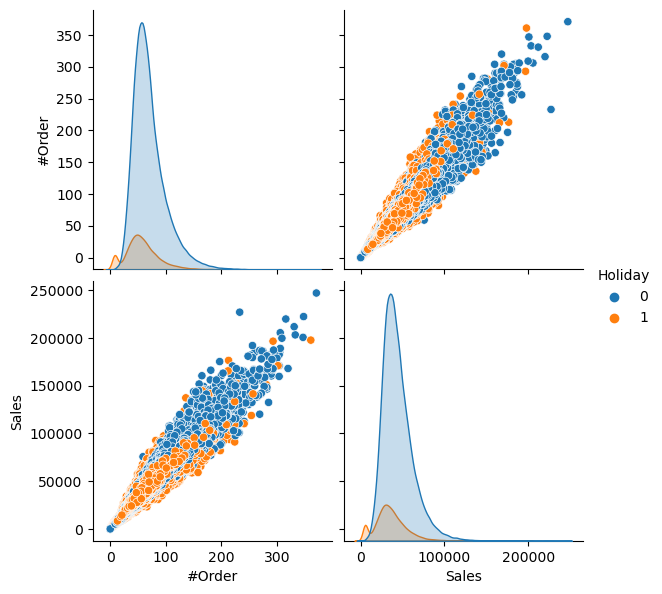

In [23]:
numeric_cols = ['#Order', 'Sales']
selected_cols = numeric_cols + ['Holiday']  # Include the 'Category' column

subset_df = df[selected_cols]  # Create a new DataFrame with selected columns

sns.pairplot(data=subset_df, hue='Holiday', height=3)
plt.show()

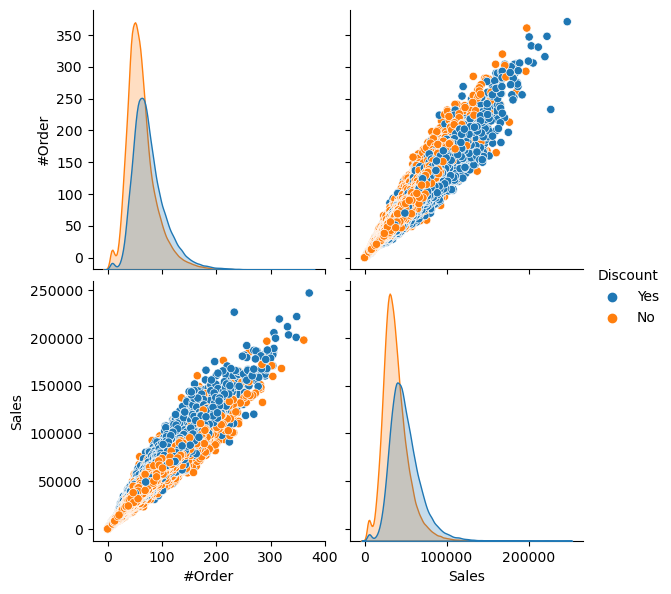

In [24]:
numeric_cols = ['#Order', 'Sales']
selected_cols = numeric_cols + ['Discount']  # Include the 'Category' column

subset_df = df[selected_cols]  # Create a new DataFrame with selected columns

sns.pairplot(data=subset_df, hue='Discount', height=3)
plt.show()

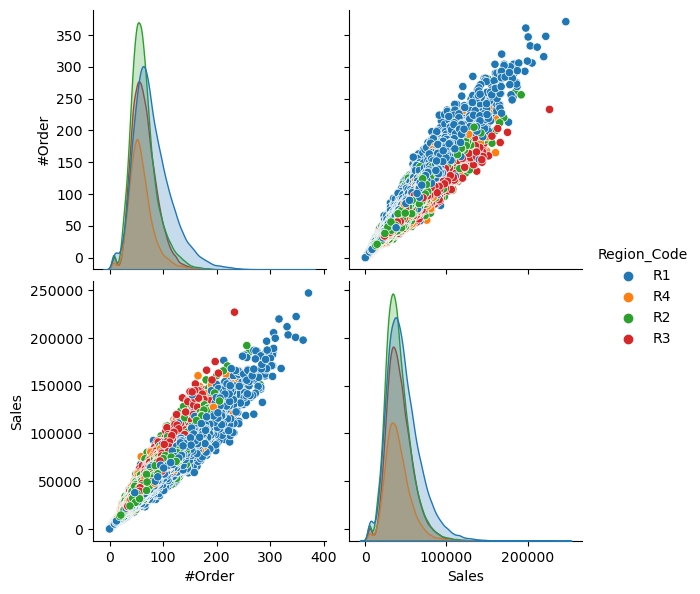

In [25]:
numeric_cols = ['#Order', 'Sales']
selected_cols = numeric_cols + ['Region_Code']  # Include the 'Category' column

subset_df = df[selected_cols]  # Create a new DataFrame with selected columns

sns.pairplot(data=subset_df, hue='Region_Code', height=3)
plt.show()

## Uji Statistik

### 1. Holiday

In [26]:
N_Holiday = df[df["Holiday"]==0]["Sales"].values
Y_Holiday = df[df["Holiday"]==1]["Sales"].values

np.var(N_Holiday), np.var(Y_Holiday)

(329181894.58875865, 354265930.2484039)

In [27]:
t_statistic, p_value = stats.ttest_ind(N_Holiday, Y_Holiday, equal_var=False, alternative='two-sided')

print("t = %.2f, p-value = %.2f" % (t_statistic,p_value))

if p_value<0.05:
    print ("Tolak H0")
else:
    print ("Gagal Menolak H0")

t = 66.18, p-value = 0.00
Tolak H0


### Derajat kebebasan

In [28]:
df_data = len(N_Holiday) + len(Y_Holiday)-2
df_data

188338

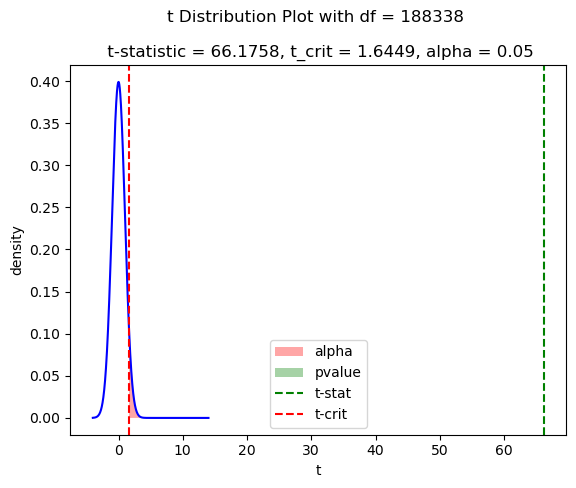

In [29]:
# plot sample distribution 
x = np.arange(-4, 14, 0.001)
plt.plot(x, stats.t.pdf(x, df = df_data), 
         color='blue')

# plot alpha region
x_alpha = np.arange(stats.t.ppf(1-0.05, df = df_data), 4, 0.01)
y_alpha = stats.t.pdf(x_alpha, df = df_data)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(t_statistic, 4, 0.01)
y_pvalue = stats.t.pdf(x_pvalue, df = df_data)

plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot t-crit and t-stats
plt.axvline(np.round(t_statistic, 4), 
            color ="green", 
            linestyle = "--", 
            label ="t-stat")

t_crit = np.round(stats.t.ppf(1-0.05, df = df_data), 4)
plt.axvline(t_crit, 
            color ="red", 
            linestyle = "--", 
            label ="t-crit")

plt.legend()
plt.xlabel("t")
plt.ylabel("density")


plt.title(f't Distribution Plot with df = {df_data} \n\n t-statistic = {np.round(t_statistic, 4)}, t_crit = {np.round(t_crit,4)}, alpha = 0.05');
plt.show()

### Confidence Level

In [30]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

cm = CompareMeans(d1 = DescrStatsW(data=N_Holiday), 
                  d2 = DescrStatsW(data=Y_Holiday))

lower, upper = cm.tconfint_diff(alpha=0.05, 
                                alternative='two-sided', 
                                usevar='unequal')

print("Confidence Interval", ":", "[", lower, upper, "]")

Confidence Interval : [ 8195.268320525198 8695.551816259655 ]


### 2. Discount

In [31]:
N_Discount = df[df["Discount"]=="No"]["Sales"].values
Y_Discount = df[df["Discount"]=="Yes"]["Sales"].values

np.var(N_Discount), np.var(Y_Discount)

(257264857.95465213, 363723771.80690634)

In [32]:
t_statistic, p_value = stats.ttest_ind(N_Discount, Y_Discount, equal_var=False, alternative='two-sided')

print("t = %.2f, p-value = %.2f" % (t_statistic,p_value))

if p_value<0.05:
    print ("Tolak H0")
else:
    print ("Gagal Menolak H0")

t = -145.93, p-value = 0.00
Tolak H0


In [33]:
df_data = len(N_Discount) + len(Y_Discount)-2
df_data

188338

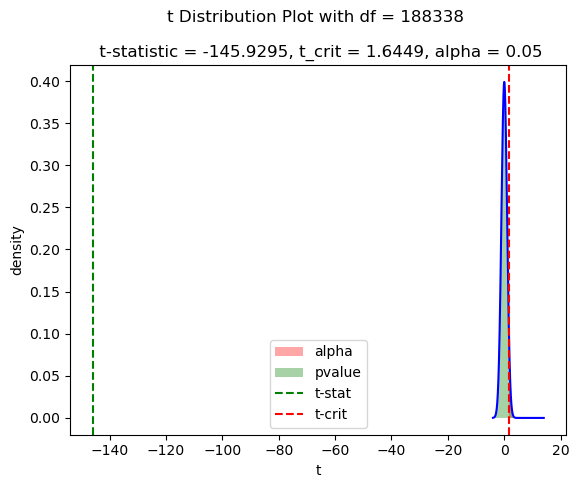

In [34]:
# plot sample distribution 
x = np.arange(-4, 14, 0.001)
plt.plot(x, stats.t.pdf(x, df = df_data), 
         color='blue')

# plot alpha region
x_alpha = np.arange(stats.t.ppf(1-0.05, df = df_data), 4, 0.01)
y_alpha = stats.t.pdf(x_alpha, df = df_data)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(t_statistic, 4, 0.01)
y_pvalue = stats.t.pdf(x_pvalue, df = df_data)

plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot t-crit and t-stats
plt.axvline(np.round(t_statistic, 4), 
            color ="green", 
            linestyle = "--", 
            label ="t-stat")

t_crit = np.round(stats.t.ppf(1-0.05, df = df_data), 4)
plt.axvline(t_crit, 
            color ="red", 
            linestyle = "--", 
            label ="t-crit")

plt.legend()
plt.xlabel("t")
plt.ylabel("density")


plt.title(f't Distribution Plot with df = {df_data} \n\n t-statistic = {np.round(t_statistic, 4)}, t_crit = {np.round(t_crit,4)}, alpha = 0.05');
plt.show()

### Confidence Level

In [35]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

cm = CompareMeans(d1 = DescrStatsW(data=N_Discount), 
                  d2 = DescrStatsW(data=Y_Discount))

lower, upper = cm.tconfint_diff(alpha=0.05, 
                                alternative='two-sided', 
                                usevar='unequal')

print("Confidence Interval", ":", "[", lower, upper, "]")

Confidence Interval : [ -12184.296391748967 -11861.339491402456 ]


### Region

In [36]:
R1 = df[df["Region_Code"] == "R1"]["Sales"]
R2 = df[df["Region_Code"] == "R2"]["Sales"]
R3 = df[df["Region_Code"] == "R3"]["Sales"]
R4 = df[df["Region_Code"] == "R4"]["Sales"]

f_statistic, p_value = stats.f_oneway(R1, R2, R3, R4)

print("F-statistic = %f, p-value = %f" % (f_statistic, p_value))

if p_value<0.05:
    print ("Tolak H0")
else:
    print ("Gagal Menolak H0")

F-statistic = 1682.425529, p-value = 0.000000
Tolak H0


## Building Regression Model

### Hapus Kolom yang Tidak Digunakan

In [37]:
df = df.drop(['ID', 'Store_id', 'Store_Type', 'Location_Type','Region_Code', 'Date'], axis=1)
df.head()

,Holiday,Discount,#Order,Sales
0,1,Yes,9,7011.84
1,1,Yes,60,51789.12
2,1,Yes,42,36868.20
3,1,Yes,23,19715.16
4,1,Yes,62,45614.52


### Mengubah Data

In [38]:
df["Discount"] = df["Discount"].map({"No":0,"Yes":1})
df.head()

,Holiday,Discount,#Order,Sales
0,1,1,9,7011.84
1,1,1,60,51789.12
2,1,1,42,36868.20
3,1,1,23,19715.16
4,1,1,62,45614.52


### Single Predictor Modelling

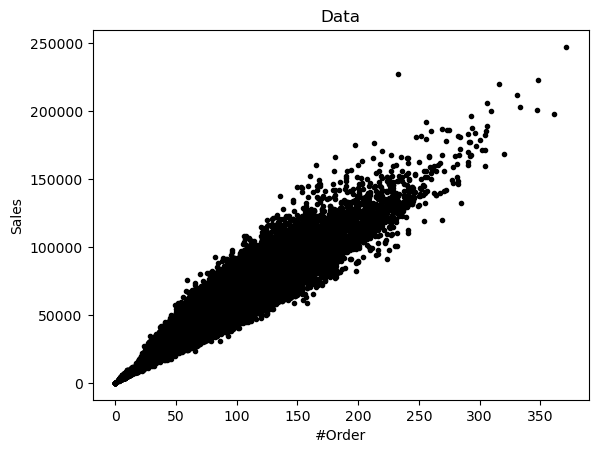

In [39]:
x = df["#Order"]
y = df["Sales"]

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels
plt.xlabel("#Order")
plt.ylabel("Sales")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

### Fit Linear Regression - Using Horsepower Variable

In [40]:
# Ganti nama kolom '#Order' menjadi 'Order'
df.rename(columns={'#Order': 'Order'}, inplace=True)

# Buat model regresi
model = smf.ols("Sales ~ Order", df)

# Fit the model
results_model = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results = print_coef_std_err(results_model)
results


,coef,std err
Intercept,3879.278251,35.112498
Order,570.407670,0.470039


In [41]:
results_model.rsquared

0.8866116232787222

Sales = 3879.28 + (Order * 570.41)

Sales diperkirakan akan meningkat sebesar 570.41 setiap peningkatan 1 unit order. 

### Visualisasi

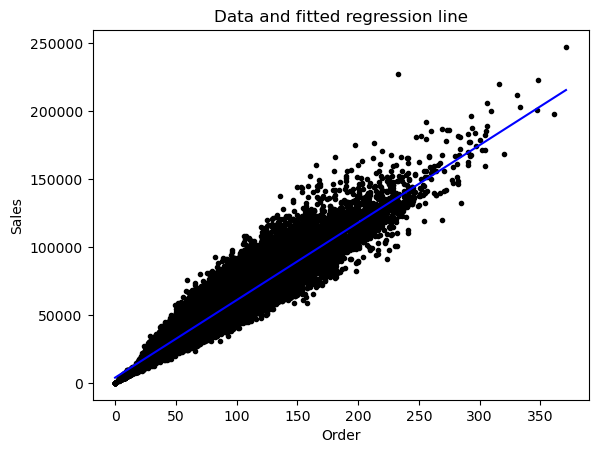

In [42]:
predictor = "Order"
outcome = "Sales"
data = df.copy()
results2 = results.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results2.loc["Intercept"]["coef"]
b_hat = results2.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

### Residual Plot

In [43]:
# Residual Plot and Explained Variance
plt.scatter(results_model.fittedvalues, results_model.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

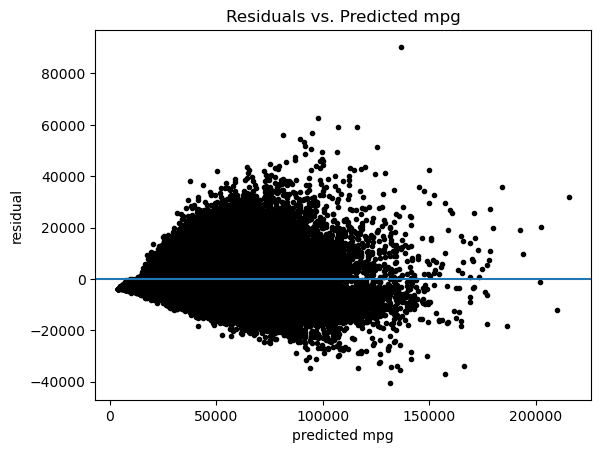

In [44]:
plt.show()

In [45]:
results_model.rsquared

0.8866116232787222

### Normality of Error Assumption

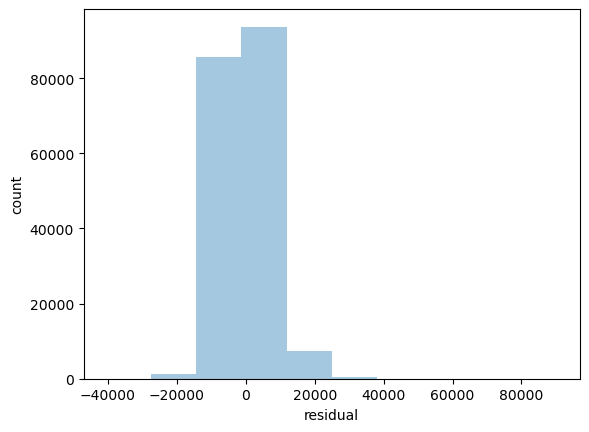

In [46]:
# Normality of Error Assumption

plt.hist(results_model.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")
plt.show()

### Fit Linear Regression - Using Log Transform on Weight Variable

In [47]:
df["logOrder"] = np.log(df["Order"])
df.loc[df["Order"] == 0, "logOrder"] = 0
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Discount,188340.0,0.447536,0.497241,0.0,0.000000,0.000000,1.000000,1.000000
Order,188340.0,68.205692,30.467415,0.0,48.000000,63.000000,82.000000,371.000000
Sales,188340.0,42784.327982,18456.708302,0.0,30426.000000,39678.000000,51909.000000,247215.000000
logOrder,188340.0,4.123523,0.468317,0.0,3.871201,4.143135,4.406719,5.916202


In [48]:
# Create OLS model object
model = smf.ols("Sales ~ logOrder", df)

# Fit the model
results_logtransform = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_sales_log = print_coef_std_err(results_logtransform)
results_logtransform.rsquared

0.7732888291541842

Hasilnya lebih rendah daripada yang tidak menggunakan transformasi. Jadi, regresi tanpa transformasi lebih baik

### Multiple Predictors Modelling

In [49]:
df.drop("logOrder", axis=1, inplace=True)
df.head()

,Holiday,Discount,Order,Sales
0,1,1,9,7011.84
1,1,1,60,51789.12
2,1,1,42,36868.20
3,1,1,23,19715.16
4,1,1,62,45614.52


In [50]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

### K-fold cross validation

In [51]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Sales ~ Order + Holiday + Discount")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                       X = df,
                                       y = df["Sales"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                    columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.901927,Folds 1
1,0.896969,Folds 2
2,0.898578,Folds 3
3,0.899242,Folds 4
4,0.897691,Folds 5


In [52]:
scores_ols_all_pred["test_rsquared"].mean()

0.8988811828470205

Model ini bisa menjelaskan 89.89% varience dari Sales.

### Fit Linear Regression - Using All Predictors

In [53]:
# Create OLS model object
model = smf.ols("Sales ~ Order + Holiday + Discount", df)

# Fit the model
results_model_sales = model.fit()

# Extract the results (Coefficient and Standard Error) to DataFrame
results_sales = print_coef_std_err(results_model_sales)
results_sales

,coef,std err
Intercept,3476.055701,34.844818
Holiday[T.1],-1577.284231,40.437465
Order,552.147256,0.461606
Discount,4148.368690,28.008722


### Centering Predictor Order

In [54]:
mean_order = df["Order"].mean()
mean_order = np.round(mean_order,0)
mean_order

68.0

In [55]:
# Menghitung rata-rata "Order"
order_mean = df["Order"].mean()

# Membuat variabel "OrderCentered" yang merupakan "Order" yang telah di-center
df["OrderCentered"] = df["Order"] - order_mean

In [57]:
# Create a class model
ols_all_pred = StatsmodelsRegressor(smf.ols, "Sales ~ Order + Holiday + Discount + OrderCentered")

# Create k-fold splitter object
kfold = KFold(n_splits=5, shuffle = True, random_state=12)

scores_ols_all_pred = cross_val_score(estimator = ols_all_pred,
                                      X = df,
                                      y = df["Sales"],
                                      cv = kfold,
                                      scoring = "r2")
scores_ols_all_pred = pd.DataFrame(data = scores_ols_all_pred, 
                                   columns=["test_rsquared"])
scores_ols_all_pred["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_pred

,test_rsquared,folds
0,0.900686,Folds 1
1,0.896791,Folds 2
2,0.899573,Folds 3
3,0.898783,Folds 4
4,0.898610,Folds 5
